In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
import pandas as pd
import sys
import re
import time
import glob
import os
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()


In [3]:
# OUTPUT_DIR = Currently same as the input directory

#'/mnt/data01/mimic-3/benchmark-notes/train'
MIMIC_NOTES_PATHS = ['/mnt/data01/mimic-3/benchmark-notes/test', '/mnt/data01/mimic-3/benchmark-notes/train']  

DEVICE = -1  # -1 is CPU otherwise the GPU device id

In [4]:
all_files = []

for path in MIMIC_NOTES_PATHS:
    files = glob.glob(path + "/*/*_notes_sent.csv")
    all_files += files

print(f"\nTotal note files: {len(all_files)}")

li = []

for filename in tqdm(all_files, desc="Load note files"):
    df = pd.read_csv(filename, index_col=None, header=0)
    df["filename"] = filename
    li.append(df)

notes = pd.concat(li, axis=0, ignore_index=True)
notes.describe(include="all")

print(f"Total notes: {len(notes)}")


Load note files:   0%|          | 21/38202 [00:00<03:03, 208.20it/s]
Total note files: 38202
Load note files: 100%|██████████| 38202/38202 [02:19<00:00, 273.36it/s]
Total notes: 724976


In [5]:
# Add patient to the table
notes["PATIENT_ID"] = notes["filename"].apply(lambda x: int(re.findall(r'/[0-9]+/', x)[-1][1:-1]))

# Add episode to the table
notes["EPISODE_ID"] = notes["filename"].apply(lambda x: int(re.findall(r'episode[0-9]+_', x)[-1][7:-1]))


In [12]:
len(notes["PATIENT_ID"].unique())

31285

In [8]:
notes[["Hours", "CATEGORY"]].groupby("CATEGORY", as_index=False).agg('count')

,CATEGORY,Hours
0,Case Management,718
1,Consult,69
2,General,5892
3,Nursing,160092
4,Nursing/other,277772
5,Nutrition,6458
6,Pharmacy,68
7,Physician,101678
8,Radiology,144810
9,Rehab Services,3643


In [13]:
# Restrict the number of notes for processing

category = ["Nursing", "Nursing/other", "Radiology"]  # or None
# category = ["Nursing/other"]  # or None
#category = None

if category != None:
    notes = notes[notes['CATEGORY'].isin(category)]

print('Number of notes: %d' %len(notes.index))

# nlp = spacy.load('en_core_sci_md', disable=['tagger','ner', 'lemmatizer'])
# nlp.add_pipe('sbd_component', before='parser')  

Number of notes: 582674


In [11]:
notes[notes["EPISODE_ID"] > 5].head(5)

,Hours,CATEGORY,DESCRIPTION,TEXT,filename,PATIENT_ID,EPISODE_ID
6730,9.737778,Nursing/other,Report,NARRATIVE NOTE: PT WAS ADM HERE FROM\n[**Hospi...,/mnt/data01/mimic-3/benchmark-notes/test/26523...,26523,7
6731,21.637778,Nursing/other,Report,NPN Days 0700-1900\nNeuro: Pt continues to exp...,/mnt/data01/mimic-3/benchmark-notes/test/26523...,26523,7
6732,23.021111,Nursing/other,Report,Addendum to Day note:\nID: pt remains on Cefep...,/mnt/data01/mimic-3/benchmark-notes/test/26523...,26523,7
6733,31.871111,Nursing/other,Report,NPN 1900 -0700\nNEURO: [**Last Name (un) 9599*...,/mnt/data01/mimic-3/benchmark-notes/test/26523...,26523,7
6734,47.037778,Nursing/other,Report,NPN Days 0700-\n1900 Pt had extremely difficul...,/mnt/data01/mimic-3/benchmark-notes/test/26523...,26523,7


In [16]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

ipykernel_launcher:3: UserWarning: FixedFormatter should only be used together with FixedLocator


[Text(0, 0.0, '0.00K'),
 Text(0, 50000.0, '50.00K'),
 Text(0, 100000.0, '100.00K'),
 Text(0, 150000.0, '150.00K'),
 Text(0, 200000.0, '200.00K'),
 Text(0, 250000.0, '250.00K'),
 Text(0, 300000.0, '300.00K')]

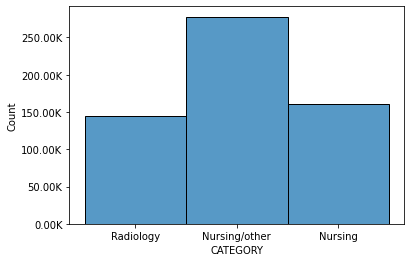

In [20]:
g = sns.histplot(data=notes, x="CATEGORY")
ylabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_yticks()/1000]
g.set_yticklabels(ylabels)

In [15]:
notes[["Hours", "CATEGORY"]].groupby("CATEGORY").agg(['count'])

,Hours
,count
CATEGORY,
Nursing,160092
Nursing/other,277772
Radiology,144810


In [17]:
len(notes["filename"].unique())

38196

In [10]:
# Load the pre-trained Bio_ClinicalBERT model
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


In [11]:
# Don't bother trying to run the pipeline without a GPU
import numpy as np
from transformers import pipeline
pipe = pipeline('feature-extraction', model=model, 
                tokenizer=tokenizer, device=DEVICE)

In [12]:
import torch 
print(torch.__version__)
print(torch.cuda.current_device())
print(torch._C._cuda_getCompiledVersion(), 'cuda compiled version')
print(torch.version.cuda)

1.8.1+cu102
0
10020 cuda compiled version
10.2


In [13]:
features = pipe(['Respiratory CAre Pt received from ED intubated for airway protection.And then another sentenc',
                  'Coughing and gagging with Sx, swallowing frequently with irritation of ETT.']  ,
                pad_to_max_length=True)
features = np.squeeze(features)
features = features[:,0,:]
features

array([[-0.03993205,  0.28045323, -0.22612181, ..., -0.36056092,
         0.02098004, -0.07117239],
       [ 0.26059031,  0.28010419, -0.19884732, ..., -0.41535112,
         0.55648196, -0.36985236]])

In [14]:
def shorten_text(sent, _max=100):
    max = _max
    tokens = sent.split()
    if len(tokens) < max:
        ret = sent
    else:
        tokens = tokens[:max]
        ret =  " ".join(tokens)
        # print(f"shorten to: {ret}")

    return ret


def get_embeddings(text, pipe, max_sents=200, max_len=100):
    sents = text.split('\n')[:-1]
    before_len = len(sents)
    sents = [x for x in sents if len(x.split()) > 1]
    sents = list(map(lambda x: shorten_text(x, max_len), sents))
    sents = sents[:max_sents]
    if len(sents) == 0:
        return None
    if len(sents) == 1:
        sents.append("books are open")

    while True:
        try:
            sent_features = pipe(sents ,pad_to_max_length=True)
        except BaseException as e:
            print("\nError in get_embeddings()")
            print('# of sentences: '+ str(len(sents)))
            sent_len = [len(x) for x in sents]
            print(sent_len)
            sent_features = None
            break
        break

    if sent_features is not None:
        try:
            sent_features = np.squeeze(sent_features)[:,0,:]
        except BaseException as e:
            print(f"Error squeezing sent_features - {e} - {len(sent_features)}-{len(sent_features[0])}")
            print('# of sentences: '+ str(len(sents)))
            sent_features = None
    
    return sent_features

In [15]:
notes["bert_embeddings"] = notes["TEXT"].iloc[:20].progress_apply(get_embeddings, args=(pipe,40,40))


100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


In [15]:
for i in range(10):
    print(notes["bert_embeddings"].iloc[i].shape)

(11, 768)
(11, 768)
(11, 768)
(7, 768)
(40, 768)
(17, 768)
(5, 768)
(40, 768)
(40, 768)
(39, 768)


In [16]:
notes.describe(include="all")

,Hours,CATEGORY,DESCRIPTION,TEXT,filename,PATIENT_ID,EPISODE_ID,bert_embeddings
count,1126.000000,1126,1126,1126,1126,1126.000000,1126.000000,1087
unique,NaN,10,63,1046,41,NaN,NaN,1087
top,NaN,Nursing,Nursing Progress Note,68 yo F with extensive PMH: MI x 3; 70 % occlu...,/mnt/data01/mimic-3/benchmark-small/train/124/...,NaN,NaN,"[[-0.023288611322641373, 0.2220444232225418, -..."
freq,NaN,502,391,7,226,NaN,NaN,1
mean,94.009515,NaN,NaN,NaN,NaN,170.079041,8.966252,NaN
std,122.909907,NaN,NaN,NaN,NaN,93.233613,7.733145,NaN
min,0.201111,NaN,NaN,NaN,NaN,23.000000,1.000000,NaN
25%,15.973056,NaN,NaN,NaN,NaN,109.000000,3.000000,NaN
50%,38.878333,NaN,NaN,NaN,NaN,124.000000,4.000000,NaN
75%,110.511389,NaN,NaN,NaN,NaN,199.000000,15.000000,NaN


In [17]:
notes.head(1)

,Hours,CATEGORY,DESCRIPTION,TEXT,filename,PATIENT_ID,EPISODE_ID,bert_embeddings
0,0.201111,Radiology,CHEST (PORTABLE AP),[**2169-5-21**]\n10:17 PM CHEST (PORTABLE AP)...,/mnt/data01/mimic-3/benchmark-small/test/345/e...,345,1,"[[0.23861932754516602, 0.09987486153841019, 0...."


In [19]:
notes["bert_embeddings"].apply(lambda x: x.tolist() if x is not None else [[]], inplace=True)

In [20]:
type(notes["bert_embeddings_list"].iloc[0])

list

In [21]:
# df.memory_usage(index=False, deep=True)

# filenames = list(notes["filename"].unique().tolist())
# for filename in tqdm(filenames, desc="Getting array sizes"):
#     df = notes[notes["filename"] == filename][["Hours", "CATEGORY", "DESCRIPTION", "bert_embeddings", "bert_embeddings_list"]]
#     size = 0
#     note_num = 0
#     for i in range(len(df)):
#         array = df["bert_embeddings_list"].iloc[i]
#         size += sys.getsizeof(array)
#         note_num += 1

#     print(f"{note_num} notes use {size} bytes of memory")

Getting array sizes: 100%|██████████| 41/41 [00:00<00:00, 569.33it/s]19 notes use 4544 bytes of memory
8 notes use 1640 bytes of memory
226 notes use 56136 bytes of memory
2 notes use 464 bytes of memory
166 notes use 39304 bytes of memory
2 notes use 328 bytes of memory
1 notes use 152 bytes of memory
2 notes use 376 bytes of memory
39 notes use 9040 bytes of memory
19 notes use 6168 bytes of memory
4 notes use 728 bytes of memory
46 notes use 12216 bytes of memory
2 notes use 456 bytes of memory
12 notes use 2832 bytes of memory
30 notes use 6480 bytes of memory
7 notes use 1704 bytes of memory
31 notes use 6576 bytes of memory
14 notes use 4312 bytes of memory
22 notes use 5496 bytes of memory
14 notes use 4008 bytes of memory
29 notes use 9952 bytes of memory
29 notes use 7968 bytes of memory
49 notes use 11512 bytes of memory
15 notes use 5032 bytes of memory
26 notes use 7136 bytes of memory
14 notes use 3792 bytes of memory
18 notes use 5968 bytes of memory
27 notes use 7104 byt

In [22]:
# Write out a new notes file with the embeddings
# aflanders: This is going to take too long and take up too much space
# The embeddings will be longer than the notes themselves. Each patient/episode
# can go from 500Kb to 18Mb

# np.set_printoptions(threshold=sys.maxsize)

filenames = list(notes["filename"].unique().tolist())
for filename in tqdm(filenames, desc="Writing embedding files"):
    df = notes[notes["filename"] == filename][["Hours", "CATEGORY", "DESCRIPTION", "bert_embeddings_list"]]
    df = df.set_index("Hours")
    write_file = filename.replace("_notes_sent.csv", "_notes_bert.parquet")
    df.to_parquet(write_file)
    # with open(write_file, "w") as f:
        # df.to_parquet(f)

Writing embedding files: 100%|██████████| 41/41 [00:02<00:00, 19.08it/s]


In [23]:
df = pd.read_parquet(write_file)
print(write_file)
df.head()

/mnt/data01/mimic-3/benchmark-small/train/236/episode3_notes_bert.parquet


,CATEGORY,DESCRIPTION,bert_embeddings_list
Hours,,,
1.911111,Radiology,CHEST (PORTABLE AP),"[[0.2817820608615875, 0.08223862946033478, 0.0..."
12.394444,Radiology,CHEST (PORTABLE AP),"[[0.23562118411064148, 0.04398752748966217, 0...."
15.127778,Radiology,BILAT LOWER EXT VEINS,"[[0.8676698207855225, 0.1013529971241951, -0.2..."
36.261111,Radiology,CHEST (PORTABLE AP),"[[0.313865065574646, 0.09958796948194504, 0.01..."


In [6]:
import pandas as pd
filename = "/mnt/data01/mimic-3/benchmark-notes/test/18837/episode1_notes_bert.parquet"
df = pd.read_parquet(filename)
print(filename)
print(df.head(20))
print(df.describe(include="all"))

/mnt/data01/mimic-3/benchmark-notes/test/18837/episode1_notes_bert.parquet
                CATEGORY DESCRIPTION  \
Hours                                  
4.333611   Nursing/other      Report   
4.333611   Nursing/other      Report   
13.450278  Nursing/other      Report   
16.800278  Nursing/other      Report   
29.583611  Nursing/other      Report   
37.050278  Nursing/other      Report   
52.150278  Nursing/other      Report   

                                              TEXT_EMBEDDING  
Hours                                                         
4.333611   [[0.4113909602165222, -0.0024229122791439295, ...  
4.333611   [[0.4113907516002655, -0.0024226978421211243, ...  
13.450278  [[0.389478474855423, 0.3938528895378113, -0.33...  
16.800278  [[0.13043050467967987, 0.25680139660835266, -0...  
29.583611  [[0.28871020674705505, 0.03684448078274727, -0...  
37.050278  [[0.3756024241447449, 0.11487705260515213, -0....  
52.150278  [[0.5176007747650146, 0.09944368153810501, -0....

In [8]:
from sys import getsizeof
getsizeof(df)
getsizeof

1739

In [26]:
all_files = []

for path in MIMIC_NOTES_PATHS:
    files = glob.glob(path + "/*/*_notes_bert.parquet")
    all_files += files

print(f"\nTotal note files: {len(all_files)}")

li = []

for filename in tqdm(all_files, desc="Load note files"):
    li.append((filename, os.path.getsize(filename)))

file_sizes = pd.DataFrame(li)
file_sizes.describe(include="all")

print(f"Total notes: {len(file_sizes)}")

file_sizes.describe(include="all")

Load note files: 100%|██████████| 950/950 [00:00<00:00, 249598.40it/s]
Total note files: 950
Total notes: 950



,0,1
count,950,9.500000e+02
unique,950,NaN
top,/mnt/data01/mimic-3/benchmark-notes/test/20181...,NaN
freq,1,NaN
mean,NaN,1.434428e+06
std,NaN,2.022282e+06
min,NaN,1.534300e+04
25%,NaN,4.392540e+05
50%,NaN,8.442175e+05
75%,NaN,1.588990e+06
